In [85]:
import numpy as np
import pandas as pd
import lightkurve as lk
from astropy.io import fits
import matplotlib.pyplot as plt
import glob, tqdm
import h5py

In [64]:
kics = pd.read_csv('matching_kic_ids.txt').values

In [65]:
kics = kics[:,0]

In [109]:
import re

def get_url_for_kepler_id(curl_file_path, target_id):
    """
    Extract the URL for a specific Kepler ID from a file containing curl commands.
    
    Args:
        curl_file_path (str): Path to the file containing curl commands
        target_id (str or int): Kepler ID to search for
        
    Returns:
        str: URL for the specified ID, or None if not found
    """
    # Convert target_id to string and remove leading zeros for comparison
    target_id = str(target_id).lstrip('0')
    
    # Read curl commands from file
    with open(curl_file_path, 'r') as file:
        curl_commands = file.read()
    
    # Define regex pattern to extract ID and URL from curl commands
    pattern = r'kplr(\d+)-q\d+.*?"(https://mast\.stsci\.edu/api/v0\.1/Download/file/\?&uri=mast:HLSP/iris/\d+/\d+/.*?)"'
    
    # Find all matches in the curl commands
    matches = re.findall(pattern, curl_commands)
    
    # Search for matching ID and return the URL
    for kepler_id, url in matches:
        if kepler_id.lstrip('0') == target_id:
            return url
    
    return None

In [320]:
quarter = 17

In [321]:
url = get_url_for_kepler_id(f"IRIS/ngc6819_q{quarter}_IRIS_lc.sh", kics[1])

In [322]:
url

'https://mast.stsci.edu/api/v0.1/Download/file/?&uri=mast:HLSP/iris/004900000/004936774/hlsp_iris_kepler_kepler_kplr004936774-q17_kepler_v1.0_lc.fits'

In [323]:
test = fits.open(url)

In [324]:
time = test[1].data['TIME']
flux = test[1].data['FLUX']

In [325]:
big_flux = np.zeros((len(kics),len(time)))
kic_list = np.zeros(len(kics))

In [326]:
for i, kic in tqdm.tqdm(enumerate(kics)):
    kic_list[i] = kic
    try:
        temp_url = get_url_for_kepler_id(f"IRIS/ngc6819_q{quarter}_IRIS_lc.sh", kic)
        temp = fits.open(temp_url)
        tt = temp[1].data['TIME']
        ff = temp[1].data['FLUX']
        temp.close()
        big_flux[i,:] = ff
    except (FileNotFoundError, ValueError):
        pass

2205it [00:10, 201.65it/s]


In [327]:
try:
    x, y = zip(*np.argwhere(big_flux==0))
    missing = np.unique(x)
except ValueError:
    missing = np.array([], dtype=int) 

In [328]:
fff = np.delete(big_flux, missing, axis=0)
final_kics = np.delete(kic_list, missing, axis=0)

In [329]:
fff.shape

(2203, 1287)

In [330]:
avg = np.nanmean(fff, axis=0)

In [331]:
smooth = np.zeros(len(time))

In [332]:
width = 300
for i in range(len(avg)):
    if i > width-1:
        sample = avg[i-width:i+width]
        smooth[i] = np.nanmean(sample,axis=0)
    else:
        sample = avg[0:i+width]
        smooth[i] = np.nanmean(sample,axis=0)

[Text(0.5, 0, 'time'), Text(0, 0.5, 'smoothed version')]

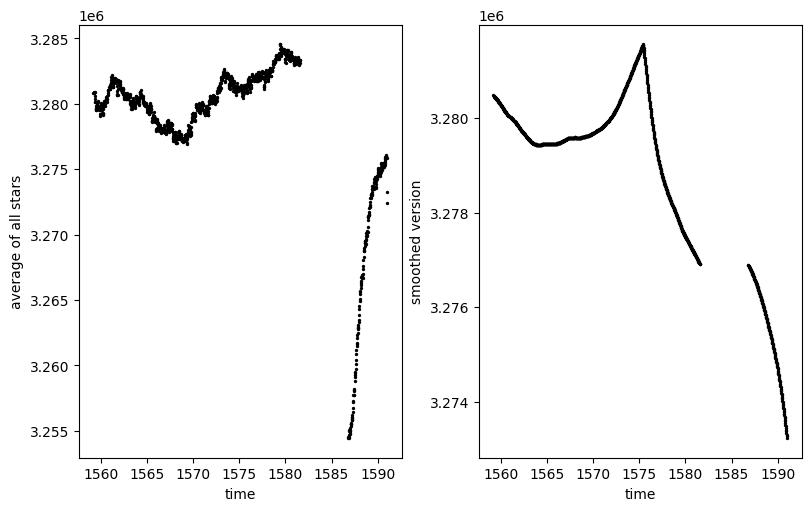

In [333]:
fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(8,5))

ax[0].scatter(time, avg, c='k', s=2)
ax[0].set(xlabel='time', ylabel='average of all stars')

ax[1].scatter(time, smooth, c='k', s=2)
ax[1].set(xlabel='time', ylabel='smoothed version')

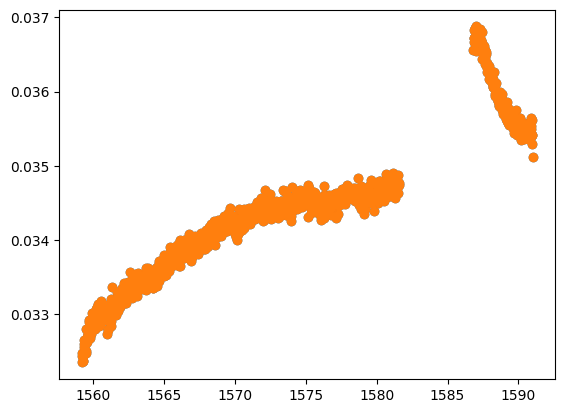

In [334]:
# %matplotlib notebook
fig, ax = plt.subplots(1)
ax.scatter(time, flux/smooth)
ax.scatter(time, fff[1]/smooth)

In [335]:
import pickle
stellar_data = {}

for i, kic_id in enumerate(final_kics):
    stellar_data[int(kic_id)] = {'flux': fff[i]/smooth, 'time': time}

with open(f'ngc6819_kepler_detrended/ngc6819_detrend_q{quarter}_kepler.pkl', 'wb') as f:
    pickle.dump(stellar_data, f)

# To load and use the data later:
with open(f'ngc6819_kepler_detrended/ngc6819_detrend_q{quarter}_kepler.pkl', 'rb') as f:
    data = pickle.load(f)

In [339]:
import os
base_dir = 'ngc6819_kepler_detrended'

quarters = [1,2,3,4,5,7,8,9,11,12,13,15,16,17]  

combined_data = {}

for quarter in quarters:
    file_path = f"{base_dir}/ngc6819_detrend_q{quarter}_kepler.pkl"
    
    if not os.path.exists(file_path):
        continue
    
    with open(file_path, 'rb') as f:
        quarter_data = pickle.load(f)
    
    for kic_id in quarter_data:
            
        # Initialize star entry in combined data if not already there
        if kic_id not in combined_data:
            combined_data[kic_id] = {'flux': [], 'time': [], 'quarters': []}
        
        combined_data[kic_id]['flux'].append(quarter_data[kic_id]['flux'])
        combined_data[kic_id]['time'].append(quarter_data[kic_id]['time'])
        combined_data[kic_id]['quarters'].append(quarter)

with open('ngc6819_combined_data.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

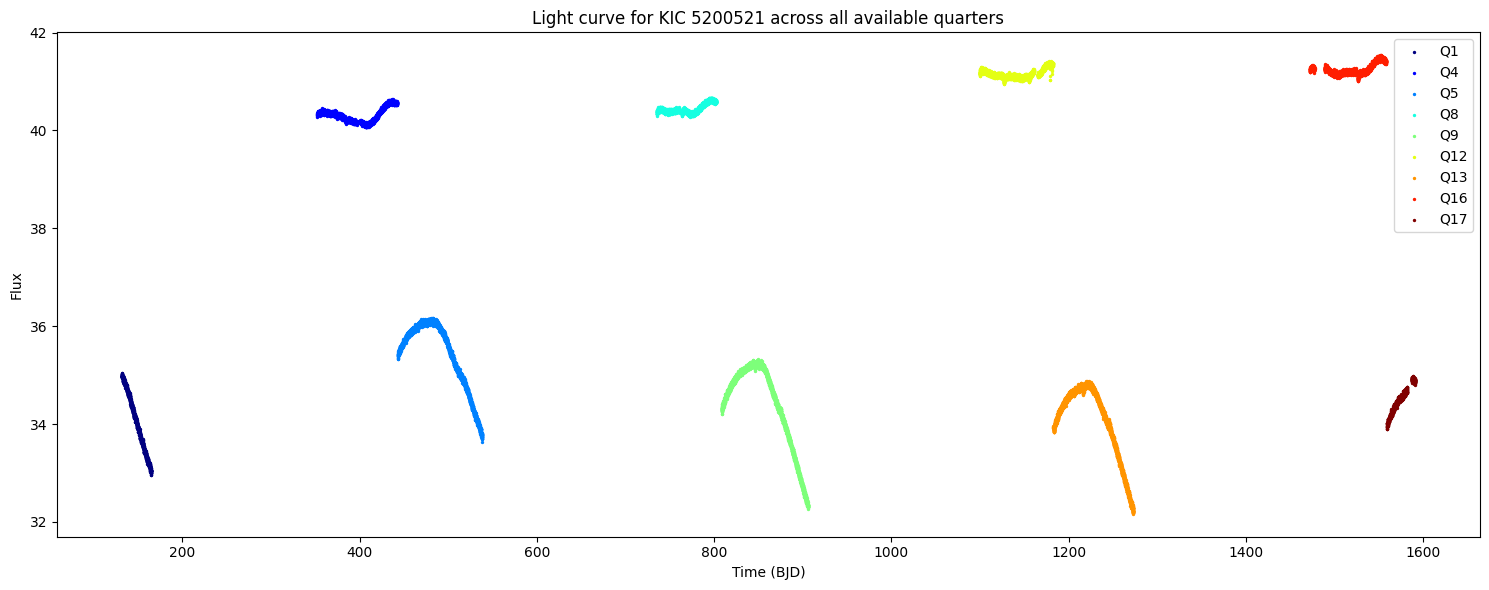

KIC 5200521 has data in 9 quarters: [1, 4, 5, 8, 9, 12, 13, 16, 17]
Total data points: 30675


In [344]:
target_kic = kic

star_data = combined_data[target_kic]
    
# Create a figure
plt.figure(figsize=(15, 6))
    
# Create a color map for different quarters
colors = plt.cm.jet(np.linspace(0, 1, len(star_data['quarters'])))

for i, quarter in enumerate(star_data['quarters']):
    flux = star_data['flux'][i]
    times = star_data['time'][i]
    
    plt.scatter(times, flux, s=2, color=colors[i], label=f'Q{quarter}')

plt.xlabel('Time (BJD)')
plt.ylabel('Flux')
plt.title(f'Light curve for KIC {target_kic} across all available quarters')

if len(star_data['quarters']) <= 10:
    plt.legend()

plt.tight_layout()
plt.show()

print(f"KIC {target_kic} has data in {len(star_data['quarters'])} quarters: {star_data['quarters']}")
print(f"Total data points: {sum(len(t) for t in star_data['time'])}")

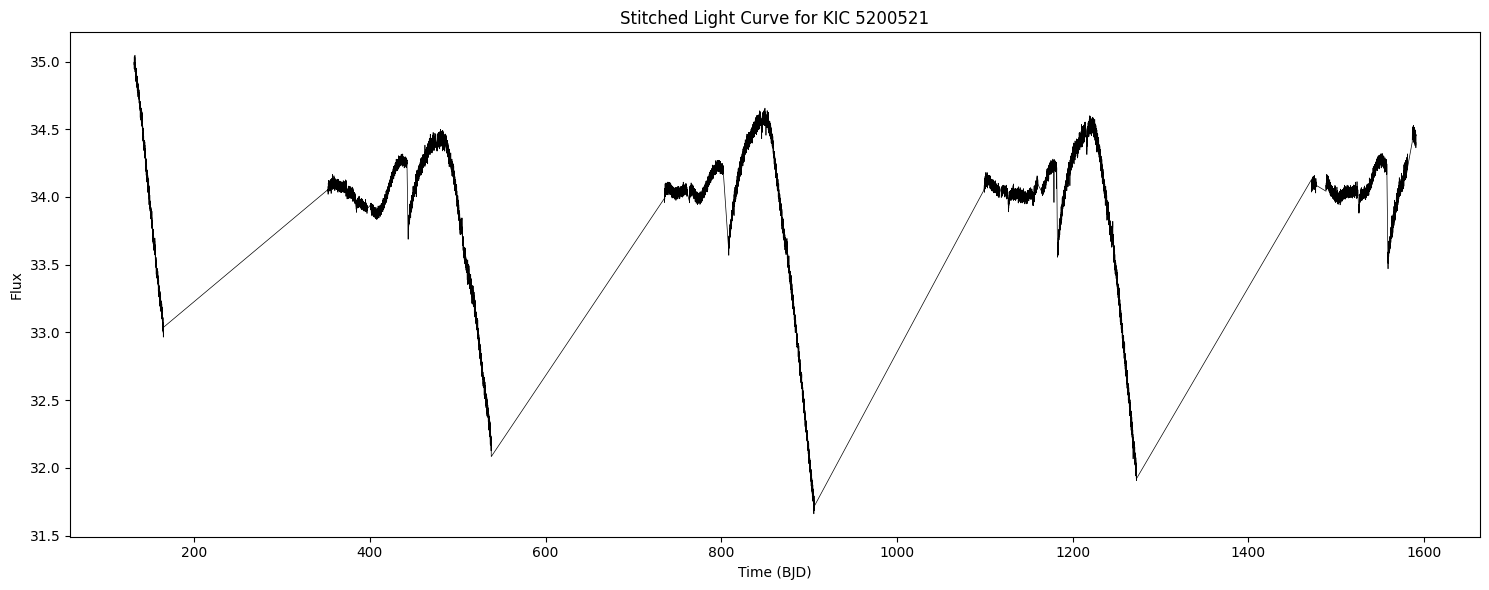

Stitched light curve for KIC 5200521
Total data points: 30675
Time span: 131.51 to 1591.00


In [ ]:
target_kic = kic

star_data = combined_data[target_kic]
    
all_times = []
all_flux = []

for i, quarter in enumerate(star_data['quarters']):
    flux = star_data['flux'][i]
    times = star_data['time'][i]
    
    # Skip if there's no data in this quarter
    if len(flux) == 0:
        continue
    
    # If this is the first quarter with data, use it as the baseline
    if len(all_flux) == 0:
        all_times = list(times)
        all_flux = list(flux)
        baseline_median = np.median(flux)
        continue
    
    # Calculate median flux for this quarter
    quarter_median = np.median(flux)
    
    # Normalize this quarter's flux to match the baseline
    scaling_factor = baseline_median / quarter_median
    adjusted_flux = flux * scaling_factor
        
    # Add this quarter's data to the stitched arrays
    all_times.extend(times)
    all_flux.extend(adjusted_flux)

# Sort the data by time to ensure proper sequence
sorted_indices = np.argsort(all_times)
all_times = np.array(all_times)[sorted_indices]
all_flux = np.array(all_flux)[sorted_indices]

# Plot the stitched light curve
plt.figure(figsize=(15, 6))
plt.plot(all_times, all_flux, 'k-', linewidth=0.5)
# plt.scatter(all_times, all_flux, s=1, c='blue')

plt.xlabel('Time (BJD)')
plt.ylabel('Flux')
plt.tight_layout()
plt.show()

print(f"Stitched light curve for KIC {target_kic}")
print(f"Total data points: {len(all_times)}")
print(f"Time span: {min(all_times):.2f} to {max(all_times):.2f}")

In [352]:
with open('ngc6819_combined_data.pkl', 'rb') as f:
    combined_data = pickle.load(f)

stitch_dir = 'ngc6819_kepler_detrended/stitched_light_curves'
if not os.path.exists(stitch_dir):
    os.makedirs(stitch_dir)

# Process each star
total_stars = len(combined_data)
processed_count = 0

for kic_id in combined_data:
    
    star_data = combined_data[kic_id]
    
    # Create arrays for stitched data
    all_times = []
    all_flux = []
    
    # For each quarter's data
    for i, quarter in enumerate(star_data['quarters']):
        flux = star_data['flux'][i]
        times = star_data['time'][i]
        
        # Skip if there's no data in this quarter
        if len(flux) == 0:
            continue
        
        # If this is the first quarter with data, use it as the baseline
        if len(all_flux) == 0:
            all_times = list(times)
            all_flux = list(flux)
            baseline_median = np.median(flux)
            continue
        
        # Calculate median flux for this quarter
        quarter_median = np.median(flux)
        
        # Normalize this quarter's flux to match the baseline
        scaling_factor = baseline_median / quarter_median
        adjusted_flux = flux * scaling_factor
        
        # Add this quarter's data to the stitched arrays
        all_times.extend(times)
        all_flux.extend(adjusted_flux)
    
    # Skip if no valid data was found
    if len(all_times) == 0:
        continue
    
    # Sort the data by time to ensure proper sequence
    sorted_indices = np.argsort(all_times)
    all_times = np.array(all_times)[sorted_indices]
    all_flux = np.array(all_flux)[sorted_indices]
    
    # Save the stitched data
    stitched_data = {
        'kic_id': kic_id,
        'times': all_times,
        'flux': all_flux,
        'quarters': star_data['quarters']
    }
    
    # Save to individual file
    with open(f'{stitch_dir}/kic_{kic_id}_stitched.pkl', 'wb') as f:
        pickle.dump(stitched_data, f)
    
    # Update progress
    processed_count += 1
    if processed_count % 10 == 0:
        print(f"Processed {processed_count}/{total_stars} stars")

# Also save a master file with all stitched light curves
master_stitched = {}
for kic_id in combined_data:
    if kic_id == 'times':
        continue
        
    file_path = f'{stitch_dir}/kic_{kic_id}_stitched.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            star_data = pickle.load(f)
        master_stitched[kic_id] = star_data

with open(f'{stitch_dir}/all_stitched_light_curves.pkl', 'wb') as f:
    pickle.dump(master_stitched, f)

print(f"Completed! Stitched light curves for {processed_count} stars")
print(f"Individual files saved in {stitch_dir}/")
print(f"Master file saved as {stitch_dir}/all_stitched_light_curves.pkl")

Processed 10/2205 stars
Processed 20/2205 stars
Processed 30/2205 stars
Processed 40/2205 stars
Processed 50/2205 stars
Processed 60/2205 stars
Processed 70/2205 stars
Processed 80/2205 stars
Processed 90/2205 stars
Processed 100/2205 stars
Processed 110/2205 stars
Processed 120/2205 stars
Processed 130/2205 stars
Processed 140/2205 stars
Processed 150/2205 stars
Processed 160/2205 stars
Processed 170/2205 stars
Processed 180/2205 stars
Processed 190/2205 stars
Processed 200/2205 stars
Processed 210/2205 stars
Processed 220/2205 stars
Processed 230/2205 stars
Processed 240/2205 stars
Processed 250/2205 stars
Processed 260/2205 stars
Processed 270/2205 stars
Processed 280/2205 stars
Processed 290/2205 stars
Processed 300/2205 stars
Processed 310/2205 stars
Processed 320/2205 stars
Processed 330/2205 stars
Processed 340/2205 stars
Processed 350/2205 stars
Processed 360/2205 stars
Processed 370/2205 stars
Processed 380/2205 stars
Processed 390/2205 stars
Processed 400/2205 stars
Processed

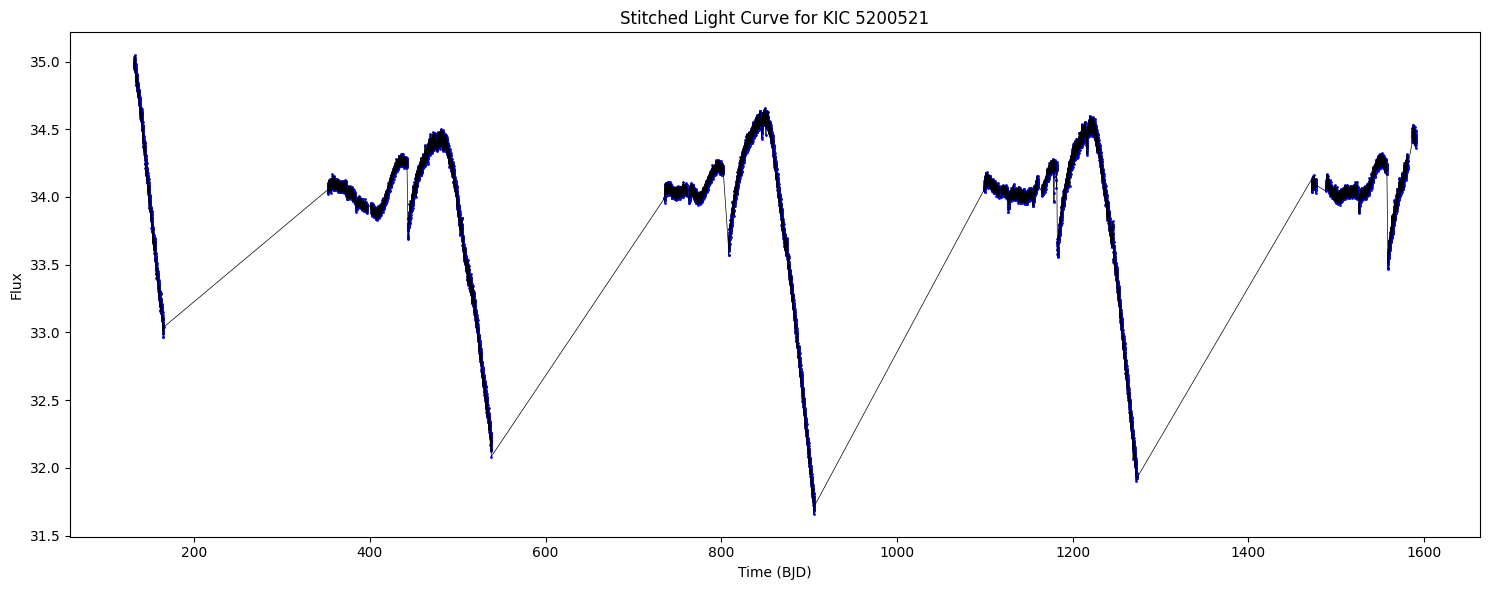

In [356]:
with open('ngc6819_kepler_detrended/stitched_light_curves/all_stitched_light_curves.pkl', 'rb') as f:
    all_stars = pickle.load(f)

target_kic = kic

if target_kic not in all_stars:
    print(f"KIC {target_kic} not found in the dataset")
else:
    star_data = all_stars[target_kic]
    
    times = star_data['times']
    flux = star_data['flux']
    
    plt.figure(figsize=(15, 6))
    
    plt.plot(times, flux, 'k-', linewidth=0.5)
    plt.scatter(times, flux, s=1, c='blue')
    
    plt.xlabel('Time (BJD)')
    plt.ylabel('Flux')
    plt.title(f'Stitched Light Curve for KIC {target_kic}')
    
    plt.tight_layout()
    plt.show()